In [179]:
from Bio import SeqIO
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl
import pickle
#installing this takes like 5 mins
#import RNA
import seaborn as sns

In [4]:
def parse_fasta(filepath):
    seqs = {}
    with open(filepath) as fasta_file:  # Will close handle cleanly
        identifiers = []
        lengths = []
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            identifiers.append(seq_record.id)
            lengths.append(len(seq_record.seq))
            seqs[seq_record.id]=str(seq_record.seq)
    return seqs

In [157]:
#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
    
def hinge(x, exp=1):
    return min(x, 6**exp)
vhinge = np.vectorize(hinge)

#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(int(30/1.5),int(15/1.5)),  cmap='Purples', edgecolors='none' )
    #ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
    #                                            x, 1))(np.unique(y)))

    ax_scatter.set_xlabel(("Model Fit ABA"), fontsize=15)
    ax_scatter.set_ylabel("In Vivo Log Fold Change", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(y, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(x, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.xlabel("Model Fit ABA")
    plt.ylabel("In Vivo Log Fold Change")
    plt.title(title)
    plt.show()
def display2(predicted, actual, title="predicted vs actual"):
    plt.figure(figsize=(6, 6))
    plt.hexbin(predicted, actual, edgecolors='none', gridsize=75,cmap='viridis',mincnt=1)
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title(title,size=16)
    plt.show()
    #now we build the table that we will use for regressions
#think of data_matrix as input and output variable as output
#seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y
def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y
def create_simple_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(len(perfect_sequence))]
                for coord in coords:
                    row[int(get_position(coord)/9)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [8]:
RATES_PATH = 'cas13-master-TilingScreens-data/TilingScreens/data/GFP_count_matrix_normalized_batchcorrected.csv'
sequences = parse_fasta('cas13-master-TilingScreens-data/TilingScreens/data/PreProcessingMetaData_data_Cas13d_GFP_library.final.fa')

In [9]:
df = pd.read_csv(RATES_PATH)
df.head()

,SC1_BIN1,SC1_BIN2,SC1_BIN3,SC1_BIN4,SC1_Input,SC2_BIN1,SC2_BIN2,SC2_BIN3,SC2_BIN4,SC2_Input,SC3_BIN1,SC3_BIN2,SC3_BIN3,SC3_BIN4,SC3_Input
crRNA001:1-27,778.444647,297.714679,319.338649,266.081657,455.147812,644.825901,227.333739,190.198970,345.874846,385.563065,779.160448,336.210142,221.579853,253.293220,522.212362
crRNA002:2-28,574.444627,251.833460,215.224495,224.072154,293.258183,549.187516,263.059505,196.420916,217.045457,293.775064,593.976968,203.390156,221.000024,218.076049,287.385918
crRNA003:6-32,434.910550,182.276368,125.990356,176.005013,174.710671,496.447045,225.639307,150.276298,109.971982,245.141463,282.508898,140.917401,178.302582,143.662488,1238.116733
crRNA004:7-33,419.941661,175.990591,169.416112,103.793553,175.989523,496.778969,197.979126,153.669423,123.908298,211.055637,393.909444,120.278801,124.857695,170.163173,246.878780
crRNA004:7-33_consecDouble_01,599.231530,150.908735,117.405077,103.647783,1022.469035,359.829870,8556.604634,102.979233,116.811154,185.816465,329.681315,93.940426,123.696649,128.656496,21626.160350


In [46]:
log_changes = {}
BIN = 2
for i, row in df.iterrows():
    if "FirstOrder_" in i:
        prefix = i.split("_FirstOrder")[0]
        try:
            original = df.loc[prefix]
        except:
            continue
        #print(original)
        mean_original = np.nanmean([np.log(original['SC1_BIN{}'.format(BIN)]/original['SC1_Input']),
                                    np.log(original['SC2_BIN{}'.format(BIN)]/original['SC2_Input']),
                                    np.log(original['SC3_BIN{}'.format(BIN)]/original['SC3_Input'])])
        mean_current = np.nanmean([np.log(row['SC1_BIN{}'.format(BIN)]/row['SC1_Input']),
                                   np.log(row['SC2_BIN{}'.format(BIN)]/row['SC2_Input']),
                                   np.log(row['SC3_BIN{}'.format(BIN)]/row['SC3_Input'])])
        log_changes[i] = mean_current-mean_original

In [47]:
log_changes

{'crRNA004:7-33_FirstOrder_01': 0.7219081131031495,
 'crRNA004:7-33_FirstOrder_02': -0.1236989197120279,
 'crRNA004:7-33_FirstOrder_03': 0.0496054025691306,
 'crRNA004:7-33_FirstOrder_04': 0.09267646122372239,
 'crRNA004:7-33_FirstOrder_05': -1.0156644973501507,
 'crRNA004:7-33_FirstOrder_06': -0.04672866086778282,
 'crRNA004:7-33_FirstOrder_07': 0.12547888628560422,
 'crRNA004:7-33_FirstOrder_08': 0.0026027893837303195,
 'crRNA004:7-33_FirstOrder_09': 0.26097869154508047,
 'crRNA004:7-33_FirstOrder_10': 0.27845604485450637,
 'crRNA004:7-33_FirstOrder_11': 1.0102031376887013,
 'crRNA004:7-33_FirstOrder_12': 0.24060589915945957,
 'crRNA004:7-33_FirstOrder_13': 0.024529648244419083,
 'crRNA004:7-33_FirstOrder_14': -0.7554269771845052,
 'crRNA004:7-33_FirstOrder_15': 0.2783463242674509,
 'crRNA004:7-33_FirstOrder_16': 0.3405792848684257,
 'crRNA004:7-33_FirstOrder_17': -0.35921622588633495,
 'crRNA004:7-33_FirstOrder_18': -0.26257104892299843,
 'crRNA004:7-33_FirstOrder_19': 0.17747940005

In [48]:
seq_to_log = {sequences[key]:log_changes[key] for key in log_changes}

In [49]:
seq_to_log

{'AACCCCGGTGAACAGCTCCTCGCCCTT': 0.7219081131031495,
 'CGCCCCGGTGAACAGCTCCTCGCCCTT': -0.1236989197120279,
 'CAACCCGGTGAACAGCTCCTCGCCCTT': 0.0496054025691306,
 'CACACCGGTGAACAGCTCCTCGCCCTT': 0.09267646122372239,
 'CACCACGGTGAACAGCTCCTCGCCCTT': -1.0156644973501507,
 'CACCCAGGTGAACAGCTCCTCGCCCTT': -0.04672866086778282,
 'CACCCCAGTGAACAGCTCCTCGCCCTT': 0.12547888628560422,
 'CACCCCGATGAACAGCTCCTCGCCCTT': 0.0026027893837303195,
 'CACCCCGGCGAACAGCTCCTCGCCCTT': 0.26097869154508047,
 'CACCCCGGTAAACAGCTCCTCGCCCTT': 0.27845604485450637,
 'CACCCCGGTGTACAGCTCCTCGCCCTT': 1.0102031376887013,
 'CACCCCGGTGACCAGCTCCTCGCCCTT': 0.24060589915945957,
 'CACCCCGGTGAATAGCTCCTCGCCCTT': 0.024529648244419083,
 'CACCCCGGTGAACCGCTCCTCGCCCTT': -0.7554269771845052,
 'CACCCCGGTGAACAACTCCTCGCCCTT': 0.2783463242674509,
 'CACCCCGGTGAACAGTTCCTCGCCCTT': 0.3405792848684257,
 'CACCCCGGTGAACAGCGCCTCGCCCTT': -0.35921622588633495,
 'CACCCCGGTGAACAGCTACTCGCCCTT': -0.26257104892299843,
 'CACCCCGGTGAACAGCTCATCGCCCTT': 0.17747940005

In [50]:
arr = [key for key in seq_to_log]
with open("GFP_structures.pkl", 'rb') as f:
    structures = pickle.load(f)

In [51]:
def dots_to_features(string):
    arr = []
    for char in string:
        if char == '.':
            arr.append(0)
        elif char == ')' or char == '(':
            arr.append(1)
    return arr


structure_features = [dots_to_features(elt) for elt in structures]

In [164]:
structure_features = np.array(structure_features)
change_values = np.array(list(seq_to_log.values()))

In [165]:
change_values = np.array([list(seq_to_log.values())[i] for i in range(len(list(seq_to_log.values()))) if len(list(a.window_20.values)[i]) == 67])

In [166]:
a.window_20.values

array(['.....((.((((..(((......)))(((((........))))))))).))..',
       '(((..(..(((((((..(((((...)))))..))..)))).)..)..)))...',
       '(((..(..(((((((..((((.....))))..))..)))).)..)..)))...', ...,
       '..........((((...(((((.(((....)))..)))))...))))',
       '..........((((((.(((((.((....)).)))))..))..))))',
       '..........((((((.(((((.((....)).)))))..))..))))'], dtype=object)

In [167]:
structure_features

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 1, 1]])

In [168]:
reg = linear_model.Ridge(alpha=1)
reg.fit(structure_features, change_values)

Ridge(alpha=1)

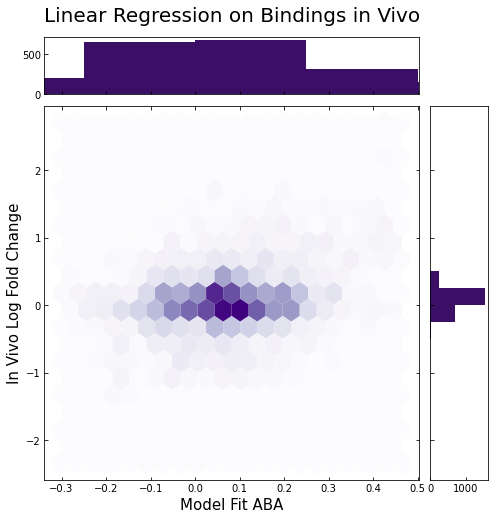

correlation is 0.2659963920249823 p-value 6.236550497085942e-42


In [169]:
predicted_output = structure_features @ reg.coef_ + reg.intercept_
display(change_values,predicted_output,  title="Linear Regression on Bindings in Vivo")
corr, p_value = pearsonr(predicted_output, change_values)
print("correlation is",corr, "p-value", p_value)

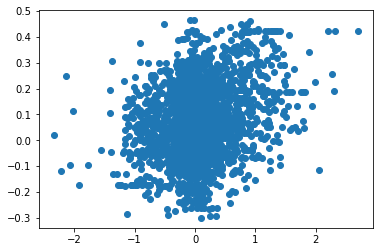

In [170]:
plt.scatter(change_values, predicted_output)

In [171]:
#make sure to install keras if you don't have the package yet
from keras import layers, models

In [172]:
#returns a CNN model given training data
def train(X, y, batch_size=100, epochs=100):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    y_ = y.reshape(len(y), 1)
    print("input shaped", (len(X[0]), 1, 1))
    
    model = models.Sequential()
    #model.add(layers.Conv2D(16, (3, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Conv2D(32, (9, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Conv2D(64, (10, 1), activation='relu'))
    model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1, activation='linear'))
    model.summary()
    
    

    #model.compile(loss='mean_squared_error',
    #              optimizer='sgd')
    model.compile(loss='logcosh',
                  optimizer='sgd')
    model.fit(X_, y_,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1
              )
    return model

#fits the data based on the trained model from above
def fit(model, X, y):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    display(vhinge(model.predict(X_)).reshape(len(X_)), y, title = "CNN on Bindings in Vivo")
    
    corr, p_value = pearsonr(vhinge((model.predict(X_)).reshape(len(X_))), y)
    print("corr is", corr)
    #return vhinge((model.predict(X_)).reshape(len(X_))), y
    
# no longer necessary  
def without_outliers(model, X, y):
    outliers = []
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    predictions = vhinge((model.predict(X_)).reshape(len(X_)))
    for i in range(len(predictions)):
        if predictions[i]-y[i] > 3:
            print("removing", predictions[i], y[i])
            predictions = np.delete(predictions, i)
            y.pop(i)

In [173]:
X,y = shuffle(structure_features, change_values)
len(X)
len(y)

2511

input shaped (27, 1, 1)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 19, 1, 32)         320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 1, 64)         20544     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 1, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                12352     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 33,281
Trainable params: 33,281
Non-trainable params: 0
__________________________

20/20 [==============================] - 0s 3ms/step - loss: 0.1105
Epoch 87/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.1011
Epoch 88/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1037
Epoch 89/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.1007
Epoch 90/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1028
Epoch 91/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.1016
Epoch 92/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1024
Epoch 93/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0977
Epoch 94/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1003
Epoch 95/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1023
Epoch 96/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1036
Epoch 97/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0983
Epoch 98/1000
20/20 [=========

20/20 [==============================] - 0s 4ms/step - loss: 0.0959
Epoch 186/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0846
Epoch 187/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0868
Epoch 188/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0894
Epoch 189/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0905
Epoch 190/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0925
Epoch 191/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0912
Epoch 192/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0954
Epoch 193/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0902
Epoch 194/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0880
Epoch 195/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0919
Epoch 196/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0917
Epoch 197/1000
20/2

20/20 [==============================] - 0s 3ms/step - loss: 0.0872
Epoch 284/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0825
Epoch 285/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0794
Epoch 286/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0844
Epoch 287/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0801
Epoch 288/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0880
Epoch 289/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0774
Epoch 290/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0795
Epoch 291/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0840
Epoch 292/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0825
Epoch 293/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0790
Epoch 294/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0814
Epoch 295/1000
20/2

20/20 [==============================] - 0s 4ms/step - loss: 0.0733
Epoch 382/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 383/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0719
Epoch 384/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0702
Epoch 385/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0716
Epoch 386/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0732
Epoch 387/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0753
Epoch 388/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0703
Epoch 389/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 390/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0763
Epoch 391/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0700
Epoch 392/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0692
Epoch 393/1000
20/2

20/20 [==============================] - 0s 4ms/step - loss: 0.0646
Epoch 480/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.0678
Epoch 481/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0677
Epoch 482/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0663
Epoch 483/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0668
Epoch 484/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0649
Epoch 485/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0673
Epoch 486/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0682
Epoch 487/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0635
Epoch 488/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0649
Epoch 489/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0644
Epoch 490/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0642
Epoch 491/1000
20/2

20/20 [==============================] - 0s 3ms/step - loss: 0.0608
Epoch 578/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0591
Epoch 579/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0595
Epoch 580/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0568
Epoch 581/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0652
Epoch 582/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 583/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0584
Epoch 584/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0596
Epoch 585/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0596
Epoch 586/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0559
Epoch 587/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0568
Epoch 588/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0570
Epoch 589/1000
20/2

20/20 [==============================] - 0s 4ms/step - loss: 0.0506
Epoch 676/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0552
Epoch 677/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0502
Epoch 678/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0554
Epoch 679/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0587
Epoch 680/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0541
Epoch 681/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0535
Epoch 682/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0579
Epoch 683/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0539
Epoch 684/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0535
Epoch 685/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0538
Epoch 686/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0562
Epoch 687/1000
20/2

20/20 [==============================] - 0s 3ms/step - loss: 0.0468
Epoch 774/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0501
Epoch 775/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0518
Epoch 776/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0493
Epoch 777/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0477
Epoch 778/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0482
Epoch 779/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0553
Epoch 780/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0470
Epoch 781/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0519
Epoch 782/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0511
Epoch 783/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0485
Epoch 784/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0533
Epoch 785/1000
20/2

20/20 [==============================] - 0s 4ms/step - loss: 0.0408
Epoch 872/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0456
Epoch 873/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0465
Epoch 874/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0484
Epoch 875/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0459
Epoch 876/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0485
Epoch 877/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0465
Epoch 878/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0501
Epoch 879/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0464
Epoch 880/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0470
Epoch 881/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0418
Epoch 882/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0420
Epoch 883/1000
20/2

20/20 [==============================] - 0s 4ms/step - loss: 0.0400
Epoch 970/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0416
Epoch 971/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0466
Epoch 972/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0417
Epoch 973/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0436
Epoch 974/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0505
Epoch 975/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0449
Epoch 976/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0472
Epoch 977/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0420
Epoch 978/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0481
Epoch 979/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0460
Epoch 980/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0411
Epoch 981/1000
20/2

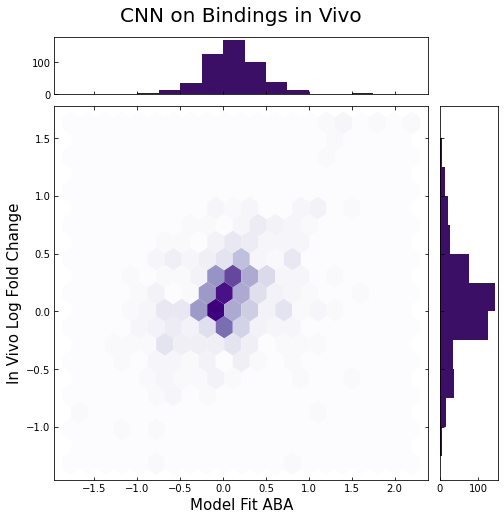

corr is 0.4439491873807847


In [174]:
X, y = shuffle(structure_features, change_values)
#this will take 5 minutes to run
X_train = X[:2000]
X_test = X[2000:]

y_train = y[:2000]
y_test = y[2000:]

model = train(X_train, y_train, epochs=1000)
fit(model, X_test, y_test)

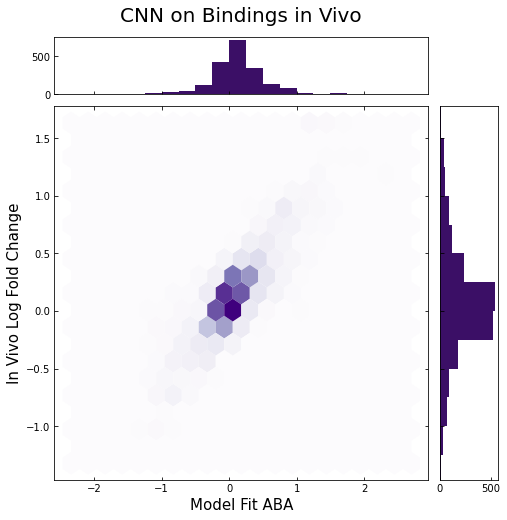

corr is 0.8353364647890504


In [176]:
fit(model, X_train, y_train)

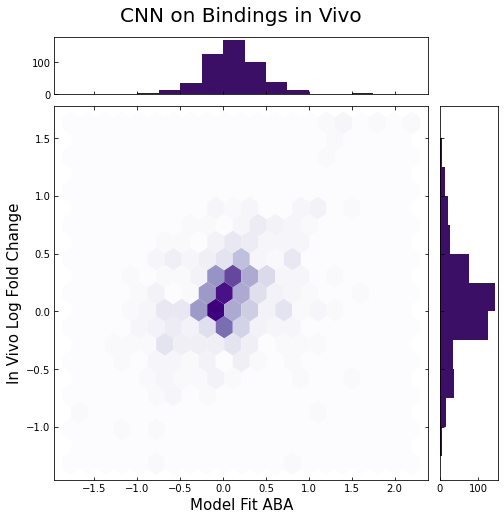

corr is 0.4439491873807847


In [175]:
fit(model, X_test, y_test)

input shaped (27, 1, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 19, 1, 32)         320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 1, 64)         20544     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 1, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                12352     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 33,281
Trainable params: 33,281
Non-trainable params: 0
__________________________

27/27 [==============================] - 0s 6ms/step - loss: 0.0906
Epoch 185/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0886
Epoch 186/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0930
Epoch 187/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0939
Epoch 188/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0925
Epoch 189/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0913
Epoch 190/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0916
Epoch 191/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0897
Epoch 192/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0948
Epoch 193/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0897
Epoch 194/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0872
Epoch 195/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0853
Epoch 196/1000
27/2

27/27 [==============================] - 0s 4ms/step - loss: 0.0709
Epoch 381/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0755
Epoch 382/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0775
Epoch 383/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0765
Epoch 384/1000
27/27 [==============================] - 0s 5ms/step - loss: 0.0748
Epoch 385/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0778
Epoch 386/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0731
Epoch 387/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0762
Epoch 388/1000
27/27 [==============================] - 0s 5ms/step - loss: 0.0742
Epoch 389/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0733
Epoch 390/1000
27/27 [==============================] - 0s 5ms/step - loss: 0.0748
Epoch 391/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0766
Epoch 392/1000
27/2

27/27 [==============================] - 0s 4ms/step - loss: 0.0637
Epoch 577/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0653
Epoch 578/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0643
Epoch 579/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0646
Epoch 580/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0647
Epoch 581/1000
27/27 [==============================] - 0s 5ms/step - loss: 0.0653
Epoch 582/1000
27/27 [==============================] - 0s 9ms/step - loss: 0.0638
Epoch 583/1000
27/27 [==============================] - 0s 9ms/step - loss: 0.0641
Epoch 584/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0647
Epoch 585/1000
27/27 [==============================] - 0s 5ms/step - loss: 0.0656
Epoch 586/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0629
Epoch 587/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0615
Epoch 588/1000
27/2

27/27 [==============================] - 0s 4ms/step - loss: 0.0596
Epoch 773/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0573
Epoch 774/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0564
Epoch 775/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0566
Epoch 776/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0551
Epoch 777/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0591
Epoch 778/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0557
Epoch 779/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0573
Epoch 780/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0576
Epoch 781/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0563
Epoch 782/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0584
Epoch 783/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0560
Epoch 784/1000
27/2

27/27 [==============================] - 0s 4ms/step - loss: 0.0503
Epoch 969/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0504
Epoch 970/1000
27/27 [==============================] - 0s 5ms/step - loss: 0.0571
Epoch 971/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.0497
Epoch 972/1000
27/27 [==============================] - 0s 5ms/step - loss: 0.0515
Epoch 973/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0518
Epoch 974/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0514
Epoch 975/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0525
Epoch 976/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0512
Epoch 977/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0574
Epoch 978/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0516
Epoch 979/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0491
Epoch 980/1000
27/2

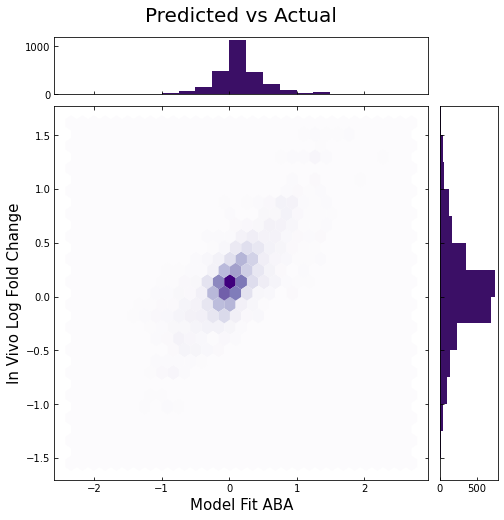

corr is 0.7554241372923789


In [71]:
model = train(structure_features, change_values, epochs=1000)
fit(model, structure_features, change_values)

In [78]:
structure_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [177]:
def create_filtered(X,y, boundary, cutoff=8, reverse=False):
    filter_y = []
    if not reverse:
        for i in range(len(X)):
            if sum(X[i][:cutoff]) >= boundary:
                filter_y.append(y[i])
    else:
        for i in range(len(X)):
            if sum(X[i][-cutoff:]) >= boundary:
                filter_y.append(y[i])
    return np.array(filter_y)
def create_filtered_equal(X,y, boundary, cutoff=8, reverse=False):
    filter_y = []
    if not reverse:
        for i in range(len(X)):
            if sum(X[i][:cutoff]) == boundary:
                filter_y.append(y[i])
    else:
        for i in range(len(X)):
            if sum(X[i][-cutoff:]) == boundary:
                filter_y.append(y[i])
    return np.array(filter_y)

In [144]:
average_aba = []
for i in range(9):
    average_aba.append(create_filtered(X,y,i).mean())

Text(0.5, 1.0, 'Log Changes (GFP) vs # of BP in Distal Region')

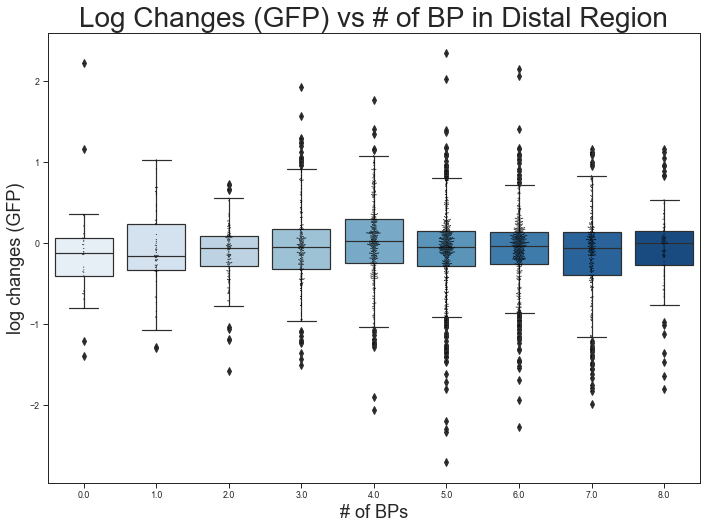

In [195]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":28,"axes.labelsize":18})
sns.set_style("ticks")
x = pd.DataFrame(columns=['log changes (GFP)', '# of BPs'])
for i in range(9):
    arr = -create_filtered_equal(X,y,i, reverse=True)
    for elt in arr:
        x = x.append({'log changes (GFP)':elt, '# of BPs':i}, ignore_index=True)
sns.swarmplot(x='# of BPs', y="log changes (GFP)", data=x, size=1, color="black")
sns.boxplot(x="# of BPs", y="log changes (GFP)", data=x, palette="Blues")
plt.title("Log Changes (GFP) vs # of BP in Distal Region", fontsize=28)

Text(0.5, 0, 'Number of Base Pairs')

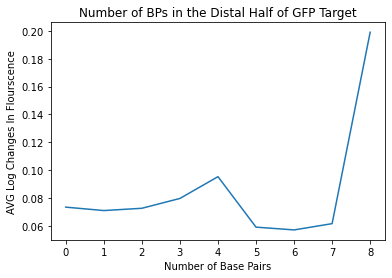

In [145]:
plt.plot(average_aba)
plt.title("Number of BPs in the Distal Half of GFP Target")
plt.ylabel("AVG Log Changes In Flourscence")
plt.xlabel("Number of Base Pairs")

Text(0, 0.5, 'Median Log Changes (GFP)')

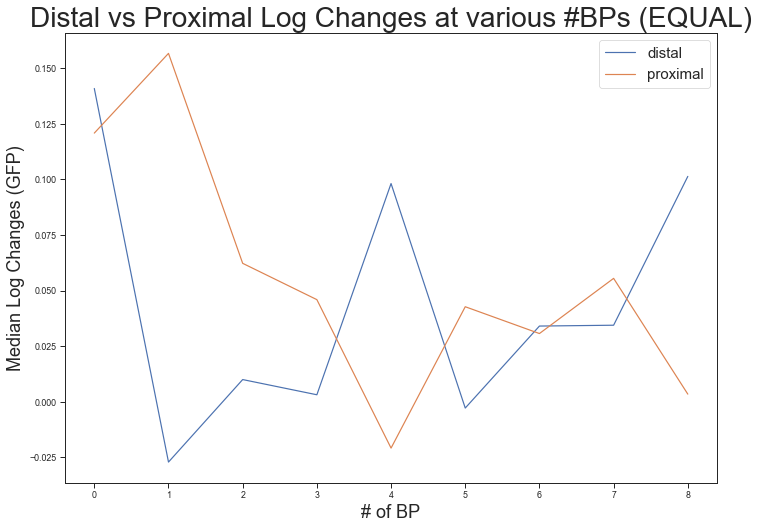

In [192]:
distal = []
prox = []
for i in range(9):
    arr = create_filtered_equal(X,y,i)
    distal.append(np.median(arr))
    arr = create_filtered_equal(X,y,i, reverse=True)
    prox.append(np.median(arr))
plt.plot(distal, label="distal")
plt.plot(prox, label="proximal")
plt.legend(prop={'size': 15})
plt.title("Distal vs Proximal Log Changes at various #BPs (EQUAL)")
plt.xlabel("# of BP")
plt.ylabel("Median Log Changes (GFP)")

In [146]:
average_aba = []
for i in range(9):
    average_aba.append(create_filtered(X,y,i, reverse=True).mean())

Text(0.5, 0, 'Number of BPs')

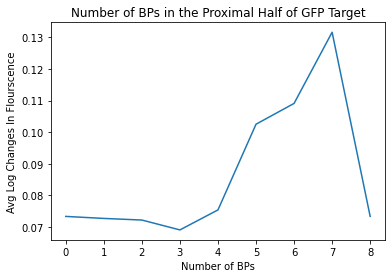

In [147]:
plt.plot(average_aba)
plt.title("Number of BPs in the Proximal Half of GFP Target")
plt.ylabel("Avg Log Changes In Flourscence")
plt.xlabel("Number of BPs")

(27.0, -1.0, -0.8, 1.5)

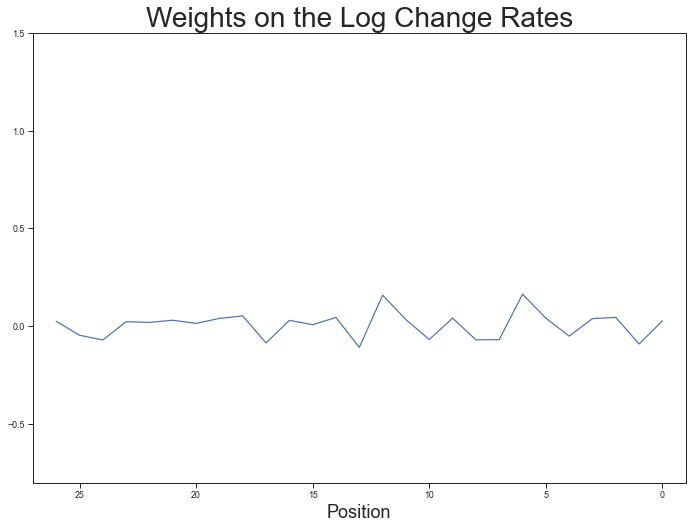

In [194]:
plt.plot(range(len(reg.coef_))[::-1],reg.coef_)
plt.title("Weights on the Log Change Rates")
plt.xlabel("Position")
plt.axis([27,-1,-.8,1.5])

Text(0.5, 0, 'Number of Bounds')

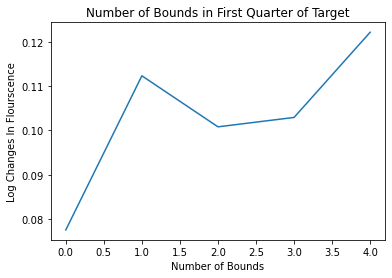

In [87]:
average_aba = []
for i in range(5):
    average_aba.append(create_filtered(X,y,i, cutoff=i+1).mean())
plt.plot(average_aba)
plt.title("Number of Bounds in First Quarter of Target")
plt.ylabel("Log Changes In Flourscence")
plt.xlabel("Number of Bounds")

Text(0.5, 0, 'Number of Bounds')

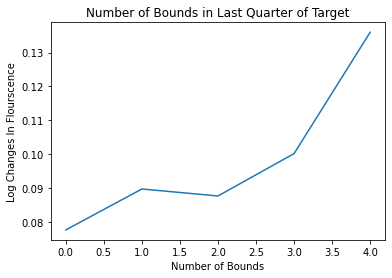

In [88]:
average_aba = []
for i in range(5):
    average_aba.append(create_filtered(X,y,i, cutoff=i+1, reverse=True).mean())
plt.plot(average_aba)
plt.title("Number of Bounds in Last Quarter of Target")
plt.ylabel("Log Changes In Flourscence")
plt.xlabel("Number of Bounds")

# increasing window sizes

In [112]:
a = pd.read_csv("gfp_free_structures.csv")

In [113]:
a.head()

,Unnamed: 0,name,window_0,window_1,window_5,window_10,window_20,window_40,window_100
0,NaN,crRNA004:7-33_FirstOrder_01,......(((((........)))))...,.......(((((........)))))....,...........(((((........)))))........,...((((((.......(((((........)))))..)))))).,.....((.((((..(((......)))(((((........)))))))...,(.((((((..((((..((...)).))))..)))))).)...........,...((((((((.(((((..((.(((.........))).))..)))....
1,NaN,crRNA004:7-33_FirstOrder_02,......(((((........)))))...,.......(((((........)))))....,(((...)))..(((((........)))))........,(((((..(((((...)))))..))..)))..............,(((..(..(((((((..(((((...)))))..))..)))).)..)....,(.((((((..((((..((...)).))))..)))))).)...((......,..(((((.(((((((((..(((((....((((....(((.(.(((....
2,NaN,crRNA004:7-33_FirstOrder_03,......(((((........)))))...,.......(((((........)))))....,..((((.....))))...(((...........)))..,(((((..((((.....))))..))..)))..............,(((..(..(((((((..((((.....))))..))..)))).)..)....,(((((....))..)))....(((..(..(((((((..((((........,...((((((((.(((((..((.(((.........))).))..)))....
3,NaN,crRNA004:7-33_FirstOrder_04,......(((((........)))))...,.......(((((........)))))....,((.......))(((((........)))))........,(((((..((((.....))))..))..)))..............,(((..(..(((((((..((((.....))))..))..)))).)..)....,(((((....))..)))....(((..(..(((((((..((((........,..(((((((((.(((((..((.(((.........))).))..)))....
4,NaN,crRNA004:7-33_FirstOrder_05,......(((((........)))))...,.......(((((........)))))....,((.....))..(((((........)))))........,(((((..((((.....))))..))..)))..............,(((..(..(((((((..((((.....))))..))..)))).)..)....,(((((....))..)))....(((..(..(((((((..((((........,..(((((.((((((((((.(((((....((((....(((.(.(((....


In [149]:
structure_features = [dots_to_features(elt[20:-20]) for elt in a.window_20 if len(elt) ==67]

In [115]:
print([len(elt) for elt in a.window_20])

[53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,